Neden Transfer Learning kullanıyoruz ?

* Benzer problemlerde basarisini kanitlamis olan olan ag mimarilerini(network architecture) kullanmak gayet mantikli. 
* Benzer veri kumesi ile calismis ve halihazirda benzer verideki oruntuleri ogrenmis bir ag isimize elbet yarar. Ayrica daha az veri ile daha iyi sonuclar elde  etmemizi saglar.


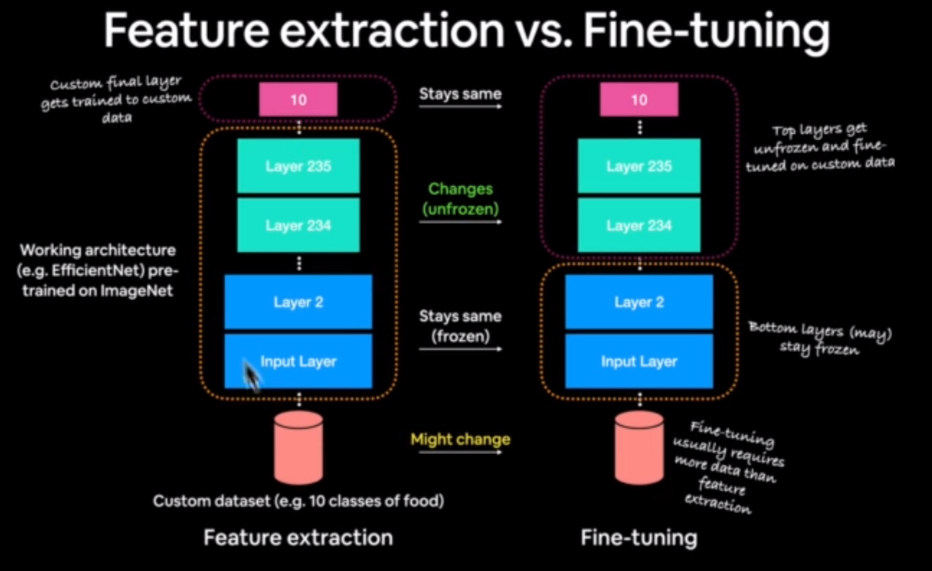

Fine-Tuning de Feature Extraction dan farkli olarak bazi ag katmanlarini verimiz ile ince ayarlamalar yapmak icin kullanacagiz.

#### ----------

Daha once yazmis oldugumuz yardimci fonksiyonlari kullanalim.

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2022-03-04 20:41:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-04 20:41:07 (72.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



Fonksiyonlari dahil edelim

In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

https://www.tensorflow.org/api_docs/python/tf/keras/applications

Verimizin sadece %10 unu kullanrak gerceklestirecegiz.

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-03-04 20:41:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.253.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   187MB/s    in 0.9s    

2022-03-04 20:41:20 (187 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



Verinin dizinlerine goz atalim

In [4]:
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [5]:
#dizinleri tanimlayalim
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

bu sefer ImageDataGenerator yerine mage_dataset_from_directory kullanacagiz

In [6]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

verimiz BatchDataset sekline donustu bu kullandigimiz fonksiyon ile ilgili. Bu fonksiyon verimizi dogrudan batch ler halina getirdi.

In [8]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

###  Functional API Kullanarak Model Olusturma

Sequential API vs Functional API farkini anlamak adina bir guuggle search 
SeqAPI biraz daha duz bir sekilde islerken, FuncAPI daha rahat hareket etmenizi saglar. Bodoslama farki bu.

In [9]:
 # 1. tf.keras.applications kullanarak base_model(temel model) tanimlayalim
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. temel modelimizi donduruyoruz cunku egitim esnasinda ogrenilmis olan oruntuleri tekrar guncellemek istemiyoruz
base_model.trainable = False 

# 3. girdi katmani 
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. ResNet50V2 gibi modellerde girdileri normalize etmemiz gerekir (EfficientNet(s) te gerekmiyor)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. girdilerimizi base_model e gecirelim
x = base_model(inputs)
print(f"inputlar modele gectikten sonra shape'i: {x.shape}")

# 6. Average pool ile base_model ciktilarina pooling uygulayalim (tum onemli bilgileri toplar, hesaplama sayisini dusurur)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"GlobalAveragePooling2D'den sonra shape'imiz: {x.shape}")

# 7. aktivasyon katmanini olusuturalim
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. input ve outputlari birlestirelim 
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model 
#modelin gelismini kaydedelim (tensorboard ile)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name= '10_percent_feature_extraction')]
                                 )

16719872/16705208 [==============================] - 0s 0us/step
inputlar modele gectikten sonra shape'i: (None, 7, 7, 1280)
GlobalAveragePooling2D'den sonra shape'imiz: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220304-205405
Epoch 1/5
24/24 [==============================] - 28s 461ms/step - loss: 1.8693 - accuracy: 0.4320 - val_loss: 1.3499 - val_accuracy: 0.6760
Epoch 2/5
24/24 [==============================] - 7s 272ms/step - loss: 1.1228 - accuracy: 0.7640 - val_loss: 0.9526 - val_accuracy: 0.7730
Epoch 3/5
24/24 [==============================] - 7s 275ms/step - loss: 0.8320 - accuracy: 0.7987 - val_loss: 0.7692 - val_accuracy: 0.8092
Epoch 4/5
24/24 [==============================] - 7s 274ms/step - loss: 0.6906 - accuracy: 0.8320 - val_loss: 0.6712 - val_accuracy: 0.8141
Epoch 5/5
24/24 [==============================] - 7s 271ms/step - loss: 0.5938 - accuracy: 0.8680 - val_loss: 0.6248 - val_accuracy: 0.8273


**Evaluate-** Modeli tum test kumesinde degerlendirelim.

In [10]:
model_0.evaluate(test_data)

79/79 [==============================] - 12s 142ms/step - loss: 0.6026 - accuracy: 0.8396


[0.6025602221488953, 0.8396000266075134]

base_model in katmanlarina gozatalim

In [11]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [12]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

Peki tum modele bakalim

In [13]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Modelin egitim surecine bakalim

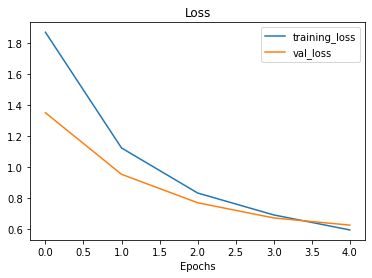

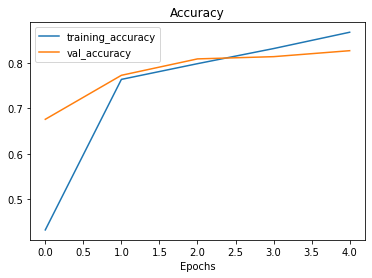

In [14]:
plot_loss_curves(history_10_percent)

training ve validation grafikte birlikte hareket ediyor bizim tam da istiyecegimiz sey

### Feature Vector
Teorik olarak arastirilmali ornek uzerinden bakalim neymis. Basitce bir ozellik tasiyan vectorler.

In [15]:
input_shape = (1, 4, 4, 3)

#rastgele tensorler olusturalim
input_tensor = tf.random.normal(input_shape)

input_tensor

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[-0.5286504 ,  0.3306324 , -0.05229992],
         [ 2.9430664 ,  0.5720516 ,  0.7205134 ],
         [ 1.1051538 ,  1.2465054 ,  1.2787855 ],
         [ 0.25822785,  0.61764425, -0.19748762]],

        [[ 0.37833473,  1.276127  ,  1.2528377 ],
         [-1.6357727 ,  0.43019825,  0.4761321 ],
         [-1.8254923 ,  1.8968228 ,  0.10585586],
         [-0.52999246, -1.8540453 ,  1.1197817 ]],

        [[ 1.357031  ,  0.5481093 , -0.73071074],
         [-0.4045519 ,  1.4593573 ,  0.18447722],
         [-0.3010459 ,  0.1322841 , -0.6810393 ],
         [ 1.7609706 , -0.56591475,  0.40029272]],

        [[-0.71012837, -0.316525  , -0.81219304],
         [-0.0811116 , -1.2298738 ,  1.6522348 ],
         [ 0.9027498 ,  0.18092869,  0.06672974],
         [ 1.6965325 , -3.6378555 ,  1.1975614 ]]]], dtype=float32)>

Bu tensore GlobalAveragePooling islemini uygulayalim

In [16]:
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
global_average_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.27408254, 0.06790292, 0.37384194]], dtype=float32)>

Goruldugu gibi shape i azaldi. Sayilar kaybolmadi. Feature Vector dedigimiz sey vektorel bir temsilmis. Daha dusuk shape sahip bir temsili olusumus oldu.
**Pooling** boyle bisey. Farkli bir yolla taklit edelim aynisini.

Basitce Feature Vector modelin anlayacagi  sekilde input verisinin sikistirilim bir temsilidir.

In [18]:
tf.reduce_mean(input_tensor, axis=[1,2]) #1 ve 2. axis dekini ortalama ile azaltcak yani ayni islemi yapacak

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.27408254, 0.06790292, 0.37384194]], dtype=float32)>